#  Calculate timeseries of Chl a
Author: Yuchen Li

Date: 4-13-2024

About: GlobColour level 3 Chl a product from multiple sensor sources

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs


def moving_mean(data, n):
    """
    Calculate the running mean of a sequence with a specified window size using np.convolve.

    Args:
    - data (list or numpy array): The input sequence.
    - n (int): The size of the window.

    Returns:
    - numpy array: An array containing the running mean values.
    """
    # Define a boxcar filter with the specified window size
    boxcar_filter = np.ones(n) / n

    # Use np.convolve to calculate the running mean
    moving_mean = np.convolve(data, boxcar_filter, mode='valid')
    
    return moving_mean


## Preprocessing

In [22]:
# retrieve files 
avw_files = []
gsm_files = []

directory = "/Users/yuchenli/Documents/Stanford@SEA/project/data/chlorophyll/"
for filename in os.listdir(directory):
    if "_AVW" in filename:
        avw_files.append(os.path.join(directory, filename))
    elif "_GSM" in filename:
        gsm_files.append(os.path.join(directory, filename))

# Open and merge _AVW files into a single xarray dataset
if avw_files:
    avw_datasets = []
    for file in sorted(avw_files):
        # Extract time from filename
        time_str = file.split('_')[1]
        year = int(time_str[:4])
        month = int(time_str[4:6])
        day = int(time_str[6:8])
        # Create time variable
        time = xr.DataArray([pd.to_datetime(f"{year}-{month}-{day}")], dims='time')
        avw_data = xr.open_dataset(file)
        avw_data['time'] = time
        avw_datasets.append(avw_data)
    avw_dataset = xr.concat(avw_datasets, dim='time')

# Open and merge _GSM files into a single xarray dataset
if gsm_files:
    gsm_datasets = []
    for file in sorted(gsm_files):
        # Extract time from filename
        time_str = file.split('_')[1]
        year = int(time_str[:4])
        month = int(time_str[4:6])
        day = int(time_str[6:8])
        # Create time variable
        time = xr.DataArray([pd.to_datetime(f"{year}-{month}-{day}")], dims='time')
        gsm_data = xr.open_dataset(file)
        gsm_data['time'] = time
        gsm_datasets.append(gsm_data)
    gsm_dataset = xr.concat(gsm_datasets, dim='time')


In [23]:
gsm_dataset

<xarray.Dataset>
Dimensions:     (lat: 169, lon: 314, time: 1222)
Coordinates:
  * lat         (lat) float32 -5.979 -6.021 -6.063 ... -12.9 -12.94 -12.98
  * lon         (lon) float32 -146.0 -146.0 -145.9 ... -133.1 -133.0 -133.0
  * time        (time) datetime64[ns] 1997-09-06 1997-09-14 ... 2024-03-29
Data variables:
    CHL1_mean   (time, lat, lon) float32 0.1241 0.1238 0.1242 ... 0.1586 0.1484
    CHL1_flags  (time, lat, lon) float32 1.043e+04 1.043e+04 ... 2.272e+04
    CHL1_error  (time, lat, lon) float32 39.17 39.56 39.83 ... 10.03 11.7 16.48
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day SeaWiFS product
    product_name:               L3m_19970906-19970913__838617517_4_GSM-SWF_CH...
    product_type:               8-day
    product_version:            2018.4
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20240412T230728Z: globcolour_l3_extract.sh -i...
    input_files:                S1997249160807.L2_GAC_OC.nc,S1997252182317.L2...
    input_files_reprocessings:  2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,201...

In [24]:
avw_dataset

<xarray.Dataset>
Dimensions:     (lat: 169, lon: 314, time: 1007)
Coordinates:
  * lat         (lat) float32 -5.979 -6.021 -6.063 ... -12.9 -12.94 -12.98
  * lon         (lon) float32 -146.0 -146.0 -145.9 ... -133.1 -133.0 -133.0
  * time        (time) datetime64[ns] 2002-05-01 2002-05-09 ... 2024-03-29
Data variables:
    CHL1_mean   (time, lat, lon) float32 0.1173 0.1332 0.1247 ... 0.1035 0.1018
    CHL1_flags  (time, lat, lon) float32 1.043e+04 1.043e+04 ... 2.272e+04
    CHL1_error  (time, lat, lon) float32 23.1 20.28 18.37 ... 14.25 15.78 21.65
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day merged MERIS/SeaWiFS product
    product_name:               L3m_20020501-20020508__838617517_4_AVW-MERSWF...
    product_type:               8-day
    product_version:            2018.4
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20240412T230937Z: globcolour_l3_extract.sh -i...
    input_files:                MER_RR__2PNACR20020430_204951_000026372005_00...
    input_files_reprocessings:  MEGS/8.0     L,MEGS/8.0     L,MEGS/8.0     L,...

In [25]:
# save the datasets
avw_dataset.to_netcdf('../data/chlorophyll/ChlA_20020501-20240329_AVW.nc')
gsm_dataset.to_netcdf('../data/chlorophyll/ChlA_19970906-20240329_GSM.nc')


## Analysis

In [2]:
ds = xr.open_dataset('../data/chlorophyll/ChlA_19970906-20240329_GSM.nc')
chla = ds.CHL1_mean
ds

<xarray.Dataset>
Dimensions:     (lat: 169, lon: 314, time: 1222)
Coordinates:
  * lat         (lat) float32 -5.979 -6.021 -6.063 ... -12.9 -12.94 -12.98
  * lon         (lon) float32 -146.0 -146.0 -145.9 ... -133.1 -133.0 -133.0
  * time        (time) datetime64[ns] 1997-09-06 1997-09-14 ... 2024-03-29
Data variables:
    CHL1_mean   (time, lat, lon) float32 ...
    CHL1_flags  (time, lat, lon) float32 ...
    CHL1_error  (time, lat, lon) float32 ...
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day SeaWiFS product
    product_name:               L3m_19970906-19970913__838617517_4_GSM-SWF_CH...
    product_type:               8-day
    product_version:            2018.4
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20240412T230728Z: globcolour_l3_extract.sh -i...
    input_files:                S1997249160807.L2_GAC_OC.nc,S1997252182317.L2...
    input_files_reprocessings:  2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,201...

Plot the domain with the averaging domain boxed

In [23]:
def plot_map(data, dir='', save=False, time_as_title=True, title=''):
    plt.figure(figsize=(8,7))
    ax = plt.subplot(2,1, 1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(data.lon, data.lat, data, 
                       vmin=0, vmax=2, cmap='Spectral_r', transform=ccrs.PlateCarree())
    if time_as_title:
        if 'time' in data.dims: 
            date = np.datetime_as_string(data.time.values, unit='D')
            plt.title(date)
        else:
            ValueError('dataarray does not have time dimension')
    else:
        plt.title(title)

    ax.coastlines()
    ax.set_xticks(np.linspace(-146, -134, 7), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-13, -6, 8), crs=ccrs.PlateCarree())

    # draw bounding box
    x_min, x_max = -142, -138
    y_min, y_max = -11, -8
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                        linewidth=1, edgecolor='w', facecolor='none')
    plt.gca().add_patch(rect)

    cbar = plt.colorbar(im, orientation='vertical')
    cbar.set_label(fr'Chlorophyll (mg/m$^3$)')
    if save and time_as_title:
        plt.savefig(f'{dir}/{date}.jpg', dpi=300, bbox_inches='tight')
        plt.close()
    else: plt.show()

# for i in range(len(chla.time)): 
#     print(i)
#     plot_map(chla[i], 'chlorophyll_frames')

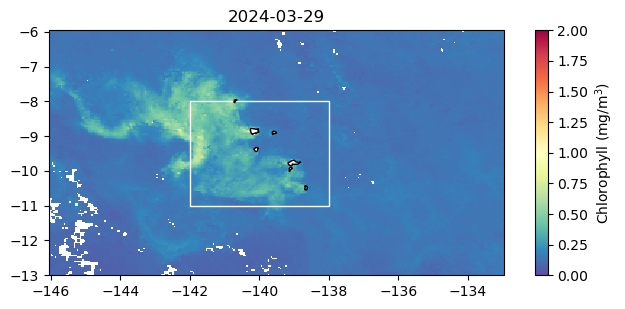

In [4]:
plot_map(chla[-1])

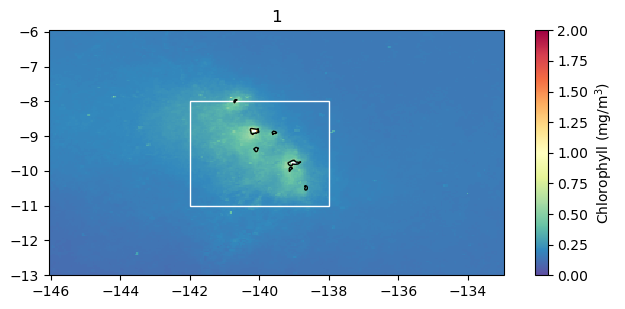

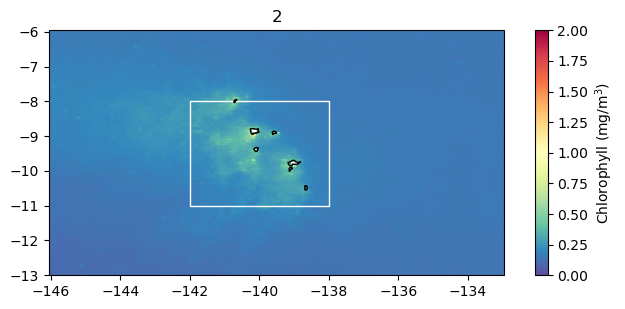

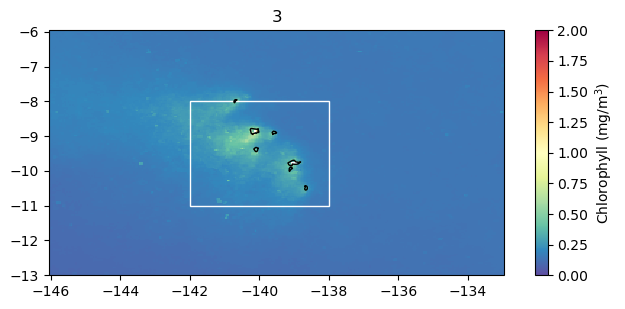

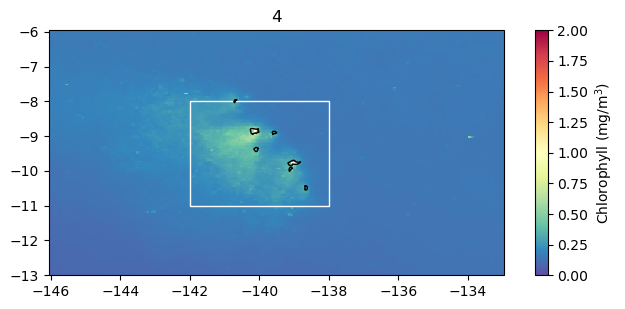

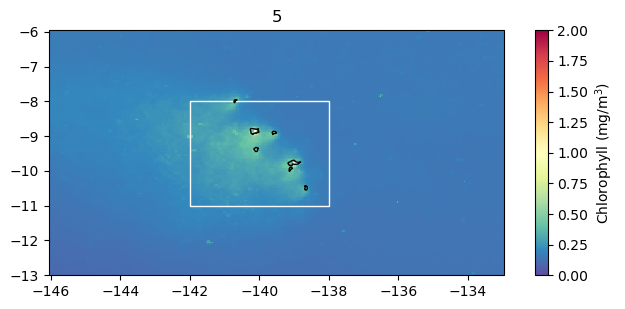

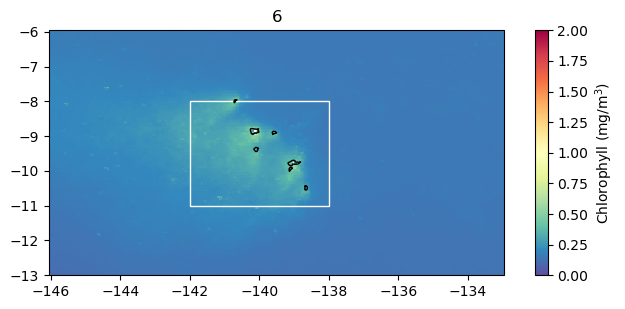

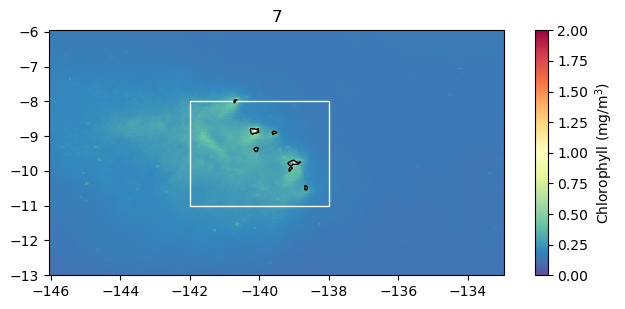

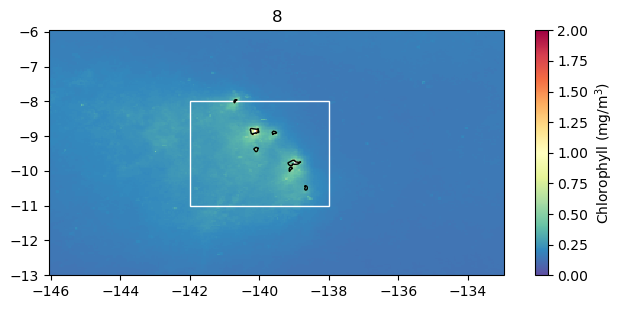

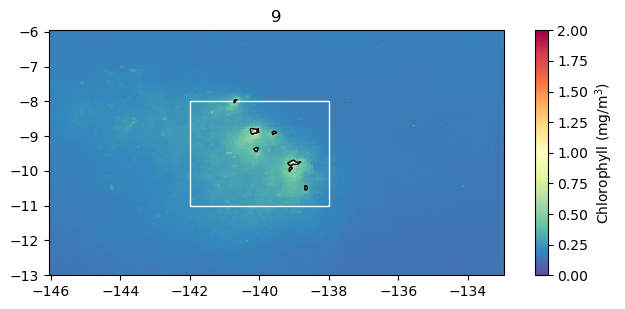

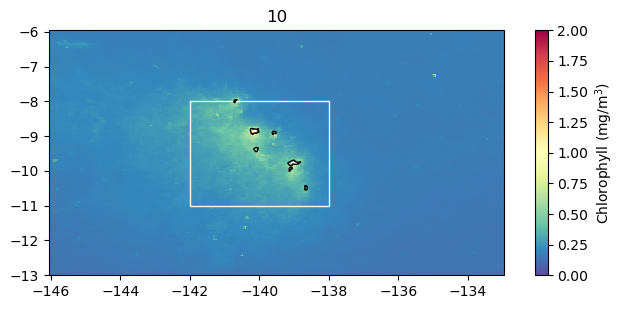

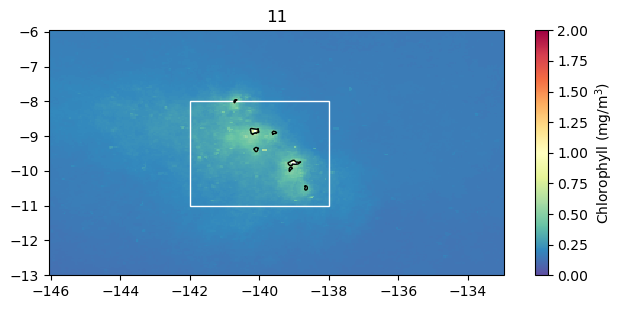

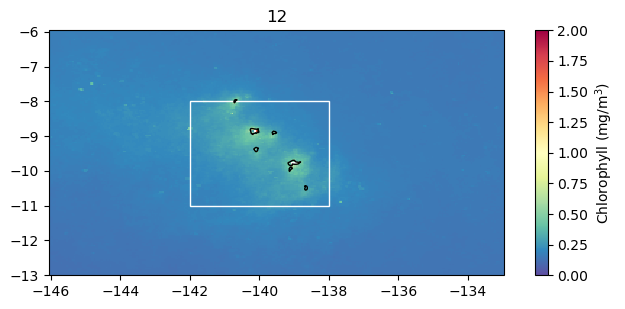

In [27]:
# plot the seasonal differences
chla_mon = []
for mon in range(1,13):
    chla_mon_mean = chla.sel(time=chla['time.month']==mon).mean('time')
    chla_mon_mean.expand_dims('time')
    chla_mon_mean['time'] = np.datetime64(f'2024-{mon:02d}-01T00:00:00')    
    plot_map(chla_mon_mean, time_as_title=False, title=mon)

Calculate mean Chl a over 218°E–222°E and 8°S–11°S (Martinez and Maamaatuaiahutapu 2004)
1. Naively (ignoring NaN)
2. Using NaN threshold

In [35]:
chla_region = chla.sel(lat=slice(-8, -11), lon=slice(-142, -138))

# take the area-weighted average
weights = np.cos(np.deg2rad(chla_region.lat))
chla_naive_avg = chla_region.weighted(weights).mean(dim=['lat', 'lon'])

# if there is not enough data, remove 
nan_counts = chla_region.isnull().sum(dim=('lat', 'lon'))
total_points = np.size(chla_region[0])

# threshold for greatest allowed proportion of missing data 
thresh = 0.3
missing_data_mask = nan_counts/total_points <= thresh
chla_avg = chla_naive_avg.where(missing_data_mask, other=np.nan)

# calculate a rolling average with a window of 12 months
chla_smooth = chla_naive_avg.rolling(time=12, center=True).mean()

### Fourier transform and seasonality
Reveals annual (seasonal) variability

/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_7589/2105390781.py:6: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


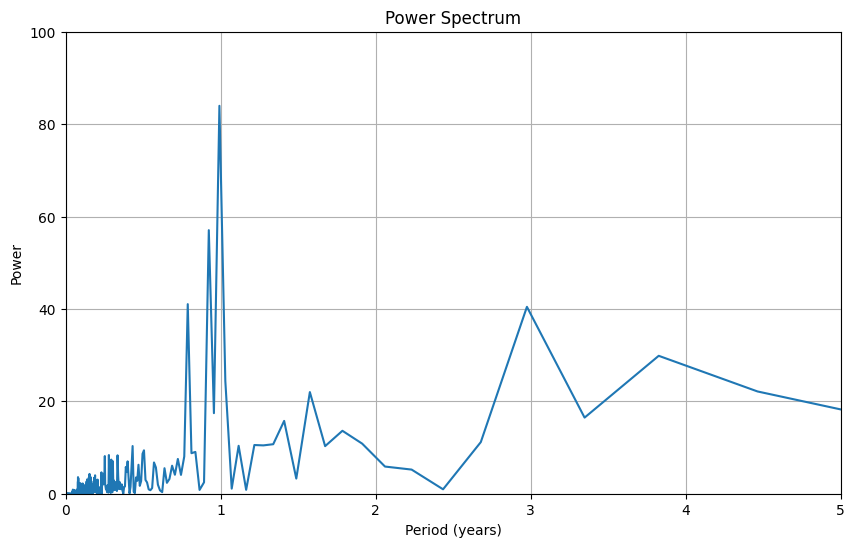

In [19]:
fourier_transform = np.fft.fft(chla_naive_avg)
power_spectrum = np.abs(fourier_transform)**2
frequencies = np.fft.fftfreq(len(chla_naive_avg), d=8)  # Assuming sampling frequency of 8 days

# Convert frequencies to periods
periods = 1 / frequencies
periods = periods[1:]  # Remove the first element to avoid division by zero

# Plot power vs period
plt.figure(figsize=(10, 6))
plt.plot(periods/365, power_spectrum[1:])
plt.xlabel('Period (years)')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.grid(True)
plt.xlim(0,5)
plt.ylim(0,100)
plt.show()


Text(0, 0.5, 'Avg Chl a')

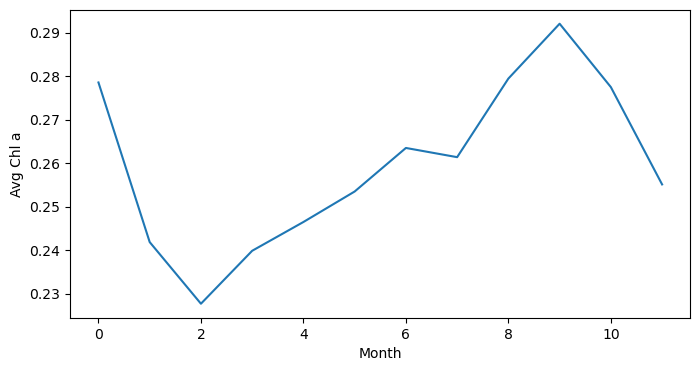

In [39]:
# print seasonal averages:
chla_region_mon = []
for mon in range(1,13):
    chla_region_mon.append(chla_region.sel(time=chla_region['time.month']==mon).mean(dim=['time', 'lat', 'lon']).values)
plt.figure(figsize=(8,4))
plt.plot(chla_region_mon)
plt.xlabel('Month')
plt.ylabel('Avg Chl a')

## SST and ENSO

In [40]:
# ENSO index
sst_ds = xr.open_dataset('../data/sst.mon.mean.nc')
sst = sst_ds.sst
nino34 = sst.sel(lat=slice(-5, 5), lon=slice(360-170, 360-120)).mean(dim=['lat', 'lon'])
nino34 = nino34.rolling(time=5, center=True).mean()

# calculate the SST in the Marquesas region 
sst_region = sst.sel(lat=slice(-11, -8), lon=slice(360-142, 360-138))
sst_region_avg = sst_region.mean(dim=['lat','lon'])

## Rainfall data
Region 5, Series 10 and 11
https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00160

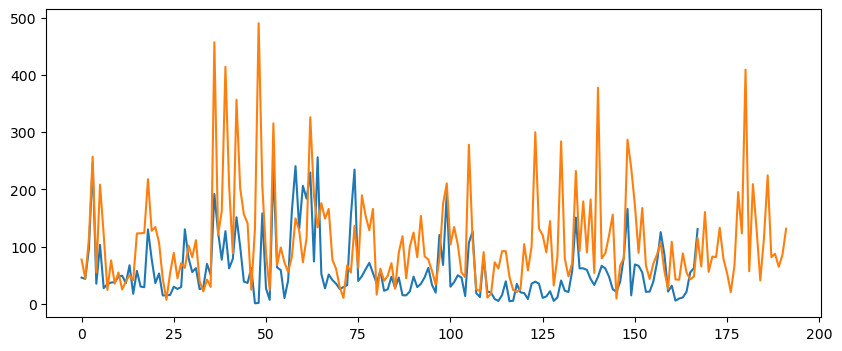

In [41]:
hivaoa_rainfall = np.loadtxt('hivaoa_rainfall.txt', dtype=str)[1:,1:-1].flatten().astype(float)
nukuhiva_rainfall = np.loadtxt('nukuhiva_rainfall.txt', dtype=str)[1:,1:-1].flatten().astype(float)
plt.figure(figsize=(10,4))
plt.plot(nukuhiva_rainfall)
plt.plot(hivaoa_rainfall) 

# Putting it all together

Text(0, 0.5, 'Marquesas SST (˚C)')

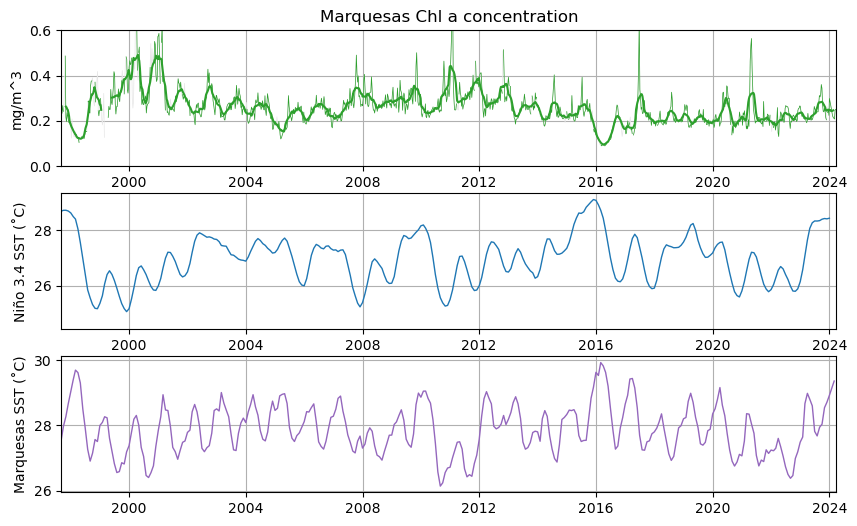

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

time = chla_naive_avg.time
ax1.plot(time, chla_naive_avg, linewidth=0.5, color=(0.9,0.9,0.9))
ax1.plot(time, chla_avg, linewidth=0.5, color='tab:green')
ax1.plot(time, chla_smooth, linewidth=1.5, color='tab:green', label='1 year running mean')
ax1.set_ylim(0,0.6)
ax1.set_xlim(time[0], time[-1])
ax1.grid(True)
ax1.set_title('Marquesas Chl a concentration')
ax1.set_ylabel('mg/m^3')

ax2.plot(nino34.time, nino34, linewidth=1)
ax2.set_xlim(time[0], time[-1])
ax2.grid(True)
ax2.set_ylabel('Niño 3.4 SST (˚C)')

ax3.plot(sst_region_avg.time, sst_region_avg, linewidth=1, color='tab:purple')
ax3.set_xlim(time[0], time[-1])
ax3.grid(True)
ax3.set_ylabel('Marquesas SST (˚C)')


todo: re-average chlorophyll data to monthly interval

In [43]:
nino34

<xarray.DataArray 'sst' (time: 511)>
array([      nan,       nan, 26.330948, 26.352896, 26.46651 , 26.807941,
       27.236103, 27.583017, 27.795364, 27.934967, 27.975996, 28.014246,
       28.054718, 28.326069, 28.52333 , 28.637518, 28.629827, 28.627012,
       28.56286 , 28.443903, 28.103521, 27.677052, 27.229252, 26.641993,
       26.092924, 25.791376, 25.620026, 25.668732, 25.873072, 26.242914,
       26.598087, 26.816275, 26.82121 , 26.751593, 26.560694, 26.320536,
       26.081312, 25.782337, 25.556747, 25.447477, 25.517073, 25.766226,
       26.104527, 26.3839  , 26.526464, 26.512144, 26.366648, 26.209955,
       26.133284, 26.042982, 25.956314, 25.947504, 26.071482, 26.28371 ,
       26.538101, 26.85081 , 27.122498, 27.220106, 27.197996, 27.19461 ,
       27.191248, 27.234915, 27.320173, 27.39893 , 27.570974, 27.755981,
       27.90515 , 28.094526, 28.256178, 28.250086, 28.211243, 28.111881,
       27.946894, 27.74977 , 27.569418, 27.337072, 27.244902, 27.158863,
       26.972227, 26.713963, 26.42778 , 26.05691 , 25.77279 , 25.41487 ,
       25.132605, 24.944723, 24.760746, 24.642694, 24.858099, 25.246632,
       25.72909 , 26.237585, 26.54106 , 26.627283, 26.58411 , 26.427612,
       26.255186, 26.196934, 26.250565, 26.348822, 26.52098 , 26.837046,
       27.137777, 27.337248, 27.447514, 27.43551 , 27.225641, 27.024525,
       26.876333, 26.788862, 26.768747, 26.80048 , 26.842875, 27.083868,
       27.344675, 27.590391, 27.772602, 27.84462 , 27.672804, 27.522482,
...
       27.134161, 27.138397, 27.175888, 27.255737, 27.352262, 27.571869,
       27.870234, 28.218124, 28.445423, 28.630436, 28.616373, 28.671955,
       28.838053, 28.935087, 29.033567, 29.119232, 29.088354, 28.925535,
       28.730072, 28.446524, 28.00442 , 27.500492, 26.996191, 26.57693 ,
       26.26862 , 26.158863, 26.138178, 26.243464, 26.523436, 26.930267,
       27.338629, 27.708134, 27.860224, 27.738464, 27.387806, 26.997858,
       26.54746 , 26.165106, 25.967274, 25.887487, 25.907679, 26.195719,
       26.618687, 27.031555, 27.333698, 27.47706 , 27.435602, 27.409254,
       27.37089 , 27.375076, 27.386292, 27.457336, 27.576548, 27.749998,
       27.971777, 28.191319, 28.249083, 28.00893 , 27.643055, 27.369476,
       27.157637, 27.022064, 27.029135, 27.096796, 27.181574, 27.374378,
       27.493286, 27.563108, 27.577147, 27.300022, 26.869497, 26.458082,
       26.08364 , 25.778355, 25.637384, 25.588083, 25.806646, 26.145452,
       26.5383  , 26.952713, 27.206991, 27.190348, 27.037226, 26.713114,
       26.361029, 26.052637, 25.874054, 25.778196, 25.854095, 26.03418 ,
       26.287205, 26.558079, 26.689915, 26.604792, 26.401691, 26.219023,
       25.978973, 25.803818, 25.793467, 25.880468, 26.14054 , 26.57115 ,
       27.090063, 27.649176, 28.075178, 28.276764, 28.341694, 28.3396  ,
       28.353638, 28.405195, 28.430103, 28.418715, 28.441736,       nan,
             nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2024-03-01